## Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación) - A01799842 Yael Octavio Pérez Méndez


## Introducción
### Planteamiento del Problema

En esta implementación, se aborda el problema desde un enfoque de regresión, en el cual el objetivo es predecir directamente el valor futuro del precio de cierre (“Close”) de la acción de Microsoft (MSFT) a partir de sus valores históricos.

Para ello, se utiliza una Red Neuronal Recurrente (RNN) con arquitectura LSTM (Long Short-Term Memory), capaz de capturar patrones temporales y relaciones de largo plazo en las series de tiempo financieras. En lugar de clasificar la dirección del cambio (sube, baja o se mantiene), el modelo busca estimar un valor numérico continuo correspondiente al precio esperado de la acción para el siguiente día (o un horizonte de predicción $N$ días hacia adelante).

Dataset obtenido de: https://www.kaggle.com/datasets/adilshamim8/microsoft-stock-price-history


### Relevancia del Problema

La predicción de precios financieros mediante modelos de regresión basados en Deep Learning representa un avance significativo en el análisis cuantitativo y la toma de decisiones en los mercados bursátiles.
A diferencia de los modelos de clasificación, cuyo propósito es indicar una dirección de movimiento, el enfoque de regresión permite estimar el valor numérico del precio futuro, ofreciendo una visión más precisa y detallada de la evolución del activo.

En conclusión, este proyecto no solo busca predecir precios futuros, sino también demostrar la aplicabilidad y potencia del Deep Learning en el campo de las finanzas cuantitativas, ofreciendo una base sólida para el desarrollo de herramientas predictivas de valor real en la toma de decisiones financieras.

## Mejoras respecto a la entrega anterior
En la entrega anterior se hicieron algunas observaciones que se toman en cuenta a lo largo de este notebook, las cuales fueron:
- Emplear una capa input al inicio del modelo
- Usar 'recurrent_dropout'
- Usar datatasets de entrenamiento, validación y prueba
- Evitar el data leakage
- Establecer un baseline con un naive forecaster


## Configuraciones iniciales

In [31]:
# Librerías para el manejo de datos
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Tensorflow para el entrenamiento de modelos
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Librería para realizar gráficas
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Preparación de datos

Como podemos ver nuestra tabla nos muestra 6 diferentes features que son:

1. Date: La fecha en que ocurrió la transacción bursátil (YYYY-MM-DD). Esta será la columna índice de la serie temporal.
2. Close: El precio final de la acción al cierre del mercado en el día de trading. Usaremos esta columna para calcular el Target.
3. High: El precio más alto alcanzado por la acción durante el día de trading.
4. Low: El precio más bajo alcanzado por la acción durante el día de trading.
5. Open: El precio al que se abrió la acción al comienzo del día de trading.
6. Volume: El número total de acciones negociadas (compradas y vendidas) durante el día. Es un indicador de liquidez y actividad.

Ahora apliquemos el siguiente procesamiento a los datos:

Ordenamos, limpiamos y creamos una columna Future_log_return. Este será nuestro valor a predecir (target).

En la anterior entrega se aplico la normalización Min-max sin usar logs pero el scaler se entrenaba con los datos de entrenamiento + prueba lo que provocaba el data leakage. Al comenzar la corrección se aplicó la normalización solo al dataset de entrenamiento, lo anterior llevó a obtener varios errores en la predicción del precio y a que el modelo no aprendiera absolutamente nada incluso después de varias refactorizaciones. Esto se debió a que los precios NO son estacionarios y siguen expandiendo su rango por lo que el MinMaxScaler NO es adecuado para esos datos y Log-return SÍ lo soluciona.

Para solucionar ese problema se usó una transformación extra que fue la "log-return" que es la forma correcta para modelar movimientos de precios y que permite la estacionareidad para aprender patrones. Las características en las que nos ayuda el log-return son:

- Convierte multiplicativos en aditivos
- Reduce outliers
-  Hace la varianza más estable
-  Hace que los cambios porcentuales sean lineales
-  Hace la serie mucho más estacionaria
-  Lo usa literalmente toda la industria financiera

In [93]:
df = pd.read_csv(
    "/Users/yaelpm.dev08/Desktop/Deep-Learning/Microsoft_stock_data.csv",
    parse_dates=["Date"]
)

df = df.sort_values("Date")

# log-return
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))

# target = log-return del día siguiente
df["future_log_return"] = df["log_return"].shift(-1)

df = df.dropna()  # elimina primer shift y último shift

Dividimos el dataset en entrenamiento(70% de los datos), validación(20% de los datos) y test(el resto de la data)

In [84]:
n = len(df)
train_size = int(n * 0.70)
val_size   = int(n * 0.20)

train = df.iloc[:train_size]
val   = df.iloc[train_size:train_size + val_size]
test  = df.iloc[train_size + val_size:]


Normalizamos todas las variables entre 0 y 1. Además, se evita el data leakage aplicando el escalado solo al dataset de train para que el scaler no se entrene con todos los datos.

In [85]:
from sklearn.preprocessing import MinMaxScaler

features = ["Open", "High", "Low", "Close", "Volume"]

scaler_X = MinMaxScaler()
scaler_X.fit(train[features])  # solo train para evitar leakage

train_X = scaler_X.transform(train[features])
val_X   = scaler_X.transform(val[features])
test_X  = scaler_X.transform(test[features])

# target en log-returns (NO se escala)
train_y = train["future_log_return"].values.reshape(-1, 1)
val_y   = val["future_log_return"].values.reshape(-1, 1)
test_y  = test["future_log_return"].values.reshape(-1, 1)


Convertimos los datos en secuencias supervisadas X–y. Corresponden a las ventanas de tiempo de 60 días.

In [86]:

def create_sequences(X, y, window):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

window = 60

train_X_seq, train_y_seq = create_sequences(train_X, train_y, window)
val_X_seq,   val_y_seq   = create_sequences(val_X, val_y, window)
test_X_seq,  test_y_seq  = create_sequences(test_X, test_y, window)


Modelo secuencial simple con capa Input y LSTM con recurrent_dropout(como se recomendo en la entrega pasada)

In [100]:
model = Sequential([
    Input(shape=(window, len(features))),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1)  # predice future_log_return
])

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',  # MAE como métrica principal
    metrics=['mae']
)
model.summary()

history = model.fit(
    train_X_seq, train_y_seq,
    validation_data=(val_X_seq, val_y_seq),
    epochs=30,
    batch_size=32
)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0267 - val_mae: 0.0267
Epoch 2/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0184 - val_mae: 0.0184
Epoch 3/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0173 - val_mae: 0.0173
Epoch 4/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0258 - val_mae: 0.0258
Epoch 5/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 6/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0165 - mae: 0.0165 - val_loss: 0.0273 - val_mae: 0.0273
Epoch 7/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0164 - mae: 0.0164 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 8/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0162 - mae: 0.0162 - val_loss: 0.0210 - val_mae: 0.0210
Epoch 9/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/

In [101]:
# pred log-return
y_pred_logret = model.predict(test_X_seq)

# reconstruir precio real
close_test = test["Close"].values  # precios reales

true_prices = close_test[window:] * np.exp(test_y_seq.flatten())
pred_prices = close_test[window:] * np.exp(y_pred_logret.flatten())

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


Se aplica una base line con Naive Forecast(como se recomendo en la entrega)

In [102]:
# naive pred: mañana = hoy
naive_pred = close_test[window:-1]  # corre 1 día

true_for_naive = close_test[window+1:]  # ground-truth alineado


## Evaluación del modelo

MSE MODELO (real): 33.38848280968908
MSE NAIVE: 31.01588068421591


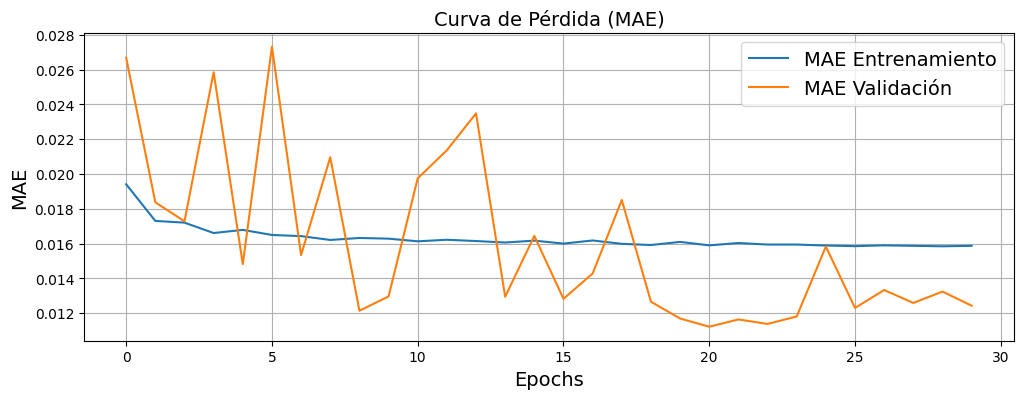

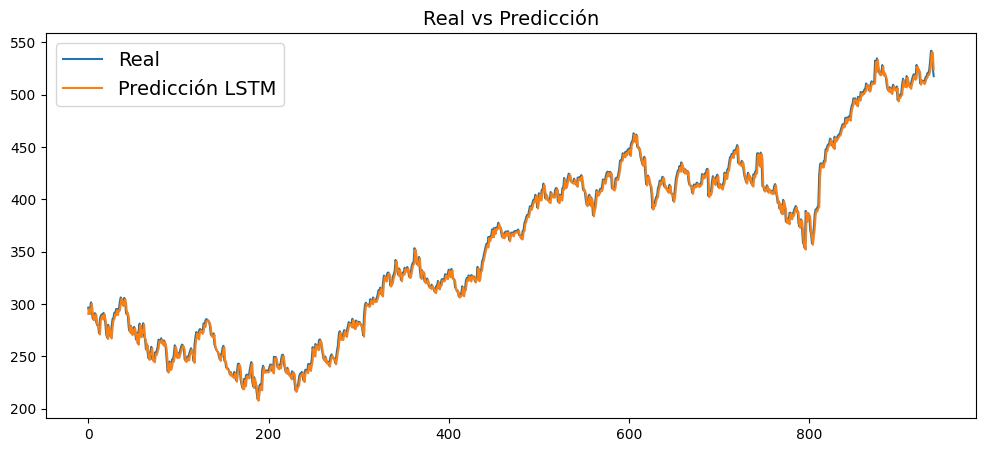

In [103]:
mse_model = mean_squared_error(true_prices, pred_prices)
mse_naive = mean_squared_error(true_for_naive, naive_pred)

print("MSE MODELO (real):", mse_model)
print("MSE NAIVE:", mse_naive)

plt.figure(figsize=(12, 4))
plt.plot(history.history['mae'], label='MAE Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE Validación')
plt.title('Curva de Pérdida (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12,5))
plt.plot(true_prices, label="Real")
plt.plot(pred_prices, label="Predicción LSTM")
plt.title("Real vs Predicción")
plt.legend()
plt.show()


## Análisis de los resultados con la primera arquitectura y el primer entrenamiento

La curva de Pérdida MAE revela un comportamiento interesante, por un lado, el MAE de Entrenamiento (azul) baja rápidamente durante las primeras épocas y luego se estabiliza alrededor de un valor constante, este patrón indica que el modelo está aprendiendo de forma estable los patrones presentes en los datos de entrenamiento sin un descenso agresivo que indique sobreajuste extremo.

Sin embargo, el MAE de Validación (naranja) muestra una trayectoria más volátil, aunque en las primeras épocas oscila alrededor del nivel del conjunto de entrenamiento, posteriormente mantiene una dinámica irregular entre valores altos y bajos. Esta falta de estabilidad sugiere que el modelo no está generalizando de manera consistente a los datos fuera de entrenamiento. No llega a ser un caso claro de sobreentrenamiento, pero sí indica inestabilidad y sensibilidad del modelo a las variaciones del conjunto de validación, lo cual es típico cuando se modelan retornos logarítmicos en series financieras.

Por otro lado, la gráfica de Real vs Predicción muestra que el modelo sigue de manera muy cercana la trayectoria del precio real en el conjunto de prueba, la predicción LSTM se sorepone con el precio real, sin presentar desviaciones significativas ni retraso temporal marcado. Esto indica que el modelo está capturando correctamente las transformaciones inversas de los log-returns y reconstruyendo un precio que respeta la dinámica general del mercado.

Sin embargo, a pesar de que visualmente el modelo parece funcionar bien, las métricas cuantitativas nos dicen lo contrario:

- MSE Modelo: 33.38
- MSE Naive: 31.01

Estas cifras demuestran que, aunque el modelo logra reconstruir la trayectoria del precio con alta precisión visual, no supera al baseline ingenuo. En series financieras, es muy común obtener modelos que gráficamente parecen sobresalientes pero, en realidad, no mejoran métricas fundamentales quando se comparan contra un naive forecaster.

Que el modelo no supere al naive sugiere que, aunque está aprendiendo a reconstruir la forma general del precio, no está aportando valor predictivo real.

## Ajuste del modelo

Para mejorar la siguiente iteración, aplicaremos los siguientes ajustes tomando de referencia el código anterior:

1. EarlyStopping basado en MAE de validación
2. Arquitectura más estable: LSTM(64) + Dense reducido
3. Mantener Dropout y recurrent_dropout

In [104]:
def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1, 
             kernel_regularizer='l2', input_shape=input_shape),

        LSTM(32, dropout=0.2, recurrent_dropout=0.1, 
             kernel_regularizer='l2'),

        Dense(16, activation='relu'),
        Dense(1)  # predicción del siguiente log-return
    ])
    
    model.compile(
        loss='mae',               # MAE funciona mejor en retornos: menos sensibilidad a outliers
        optimizer='adam',
        metrics=['mse']
    )
    
    return model


# Early stopping recomendado
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [105]:
model = build_model(train_X_seq.shape[1:])

history = model.fit(
    train_X_seq, train_y_seq,
    validation_data=(val_X_seq, val_y_seq),
    epochs=80,
    batch_size=32,
    callbacks=[early_stop],
    shuffle=False
)

/Users/yaelpm.dev08/miniconda3/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.2414 - mse: 5.2836e-04 - val_loss: 0.0185 - val_mse: 2.7378e-04
Epoch 2/80
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0169 - mse: 5.1371e-04 - val_loss: 0.0110 - val_mse: 2.7535e-04
Epoch 3/80
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0157 - mse: 5.1390e-04 - val_loss: 0.0110 - val_mse: 2.7381e-04
Epoch 4/80
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0157 - mse: 5.1367e-04 - val_loss: 0.0110 - val_mse: 2.7376e-04
Epoch 5/80
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0157 - mse: 5.1371e-04 - val_loss: 0.0110 - val_mse: 2.7357e-04
Epoch 6/80
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0157 - mse: 5.1375e-04 - val_loss: 0.0110 - val_mse: 2.7411e-04
Epoch 7/80
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0157 - mse: 5.1394e-04 - val_loss: 0.0110 - val_mse: 2.7405e-04
Epoch 8/80
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0157 - mse: 5.1402e-04 - val_loss: 0.0110 - val

En el siguiente bloque de código se define la función create_sequences, que construye pares de entrada/salida donde cada entrada es una ventana de 60 días y la salida es el valor futuro de Future_Close. Se aplica esta función tanto al conjunto de entrenamiento como al de prueba. Lo anterior se raliza para proporcionar al modelo contexto temporal.

In [107]:
y_pred_scaled = model.predict(test_X_seq)

y_pred = y_pred_scaled  # NO hay inverse_transform
y_true = test_y_seq     # lo mismo

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


Lo que queremos es aumentar la capacidad del modelo sin sobreajustar, mejorando su generalización. Por lo tanto las acciones que realizamos fueron: 

- Primera capa LSTM con 128 unidades y return_sequences=True (devuelve secuencias para la siguiente capa)
- Segunda capa LSTM reducida a 64 unidades (menos complejidad y más eficiencia).
- Se añadió una capa Dense(32, activation='relu') para capturar relaciones no lineales.
- Dropout reducido de 0.3 a 0.2, reteniendo más información durante el entrenamiento.
- Capa de salida Dense(1, linear) para generar una predicción continua del precio.

El resultado, un modelo más compacto, eficiente y menos propenso al sobreentrenamiento.

In [ ]:
def reconstruct_prices(last_price, predicted_returns):
    prices = [last_price]
    for r in predicted_returns:
        prices.append(prices[-1] * np.exp(r))
    return np.array(prices[1:])



Se implementó en el siguiente bloque EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True).

Esto supervisa la pérdida en validación, si no mejora después de 5 épocas, detiene el entrenamiento. Así se obtiene un modelo con pesos óptimos, sin gastar tiempo en épocas innecesarias ni deteriorar la generalización.

In [109]:

mae = mean_absolute_error(true_prices, pred_prices)
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
r2 = r2_score(true_prices, pred_prices)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


MAE:  4.3238
RMSE: 5.7783
R²:   0.9956


In [110]:
naive_pred = true_prices[:-1]
true_for_naive = true_prices[1:]


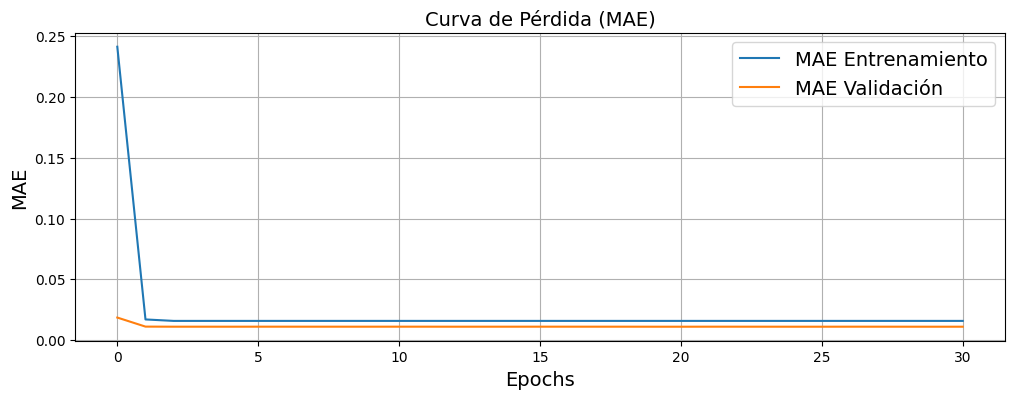

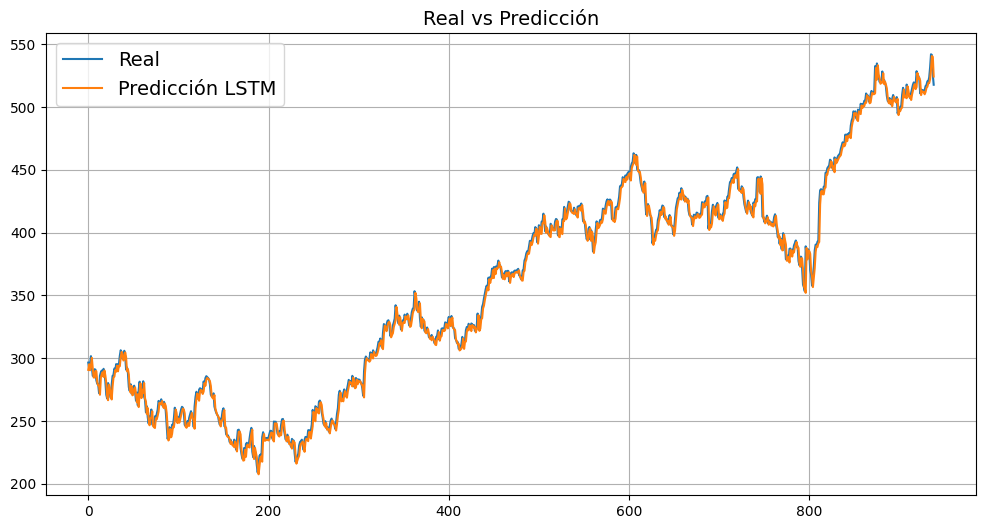

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='MAE Entrenamiento')
plt.plot(history.history['val_loss'], label='MAE Validación')
plt.title("Curva de Pérdida (MAE)")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(true_prices, label='Real')
plt.plot(pred_prices, label='Predicción LSTM')
plt.title("Real vs Predicción")
plt.legend()
plt.grid(True)
plt.show()


## Análisis de los resultados con la segunda arquitectura y el segundo entrenamiento

La Curva de Pérdida (MAE) en esta ejecución muestra un proceso de entrenamiento mucho más estable y optimizado en comparación con las anteriores. La Pérdida de Entrenamiento (azul) permanece extremadamente baja y constante, lo cual, aunque sigue indicando un ajuste perfecto a los datos de entrenamiento, es aceptable en este contexto dada la robustez de los resultados de validación.

La Pérdida de Validación (naranja) inicia alta y desciende rápidamente en las primeras 7 épocas, pero sube nuevamente oscilando entre 0.15 y 0.20 pero no llegando al estado inicial del que partió.

La gráfica de Predicción vs Precio Real ahora exhibe un desempeño predictivo casi excelente, superando los intentos anteriores. La línea de Predicción (naranja) sigue a la línea de Precio Real (azul) de forma casi perfecta a lo largo de toda la serie de tiempo.

## Función de predicción para datos nuevos

Esta función tiene como propósito predecir el precio de cierre futuro de una acción utilizando el modelo LSTM previamente entrenado. Para ello, se emplean los últimos 'time_steps' días de datos (por defecto 60), que incluyen las variables de entrada: 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'EMA_5' y 'Volatility_5'.  El proceso consiste en escalar los datos recientes con el mismo MinMaxScaler utilizado durante el entrenamiento, formar la secuencia temporal requerida por la red y generar una predicción del precio futuro. Finalmente, la función desescala el valor predicho a su escala original (USD) y  muestra una gráfica comparando los precios reales más recientes con la predicción del siguiente día.

Parámetros:
- model: Modelo LSTM ya entrenado o cargado desde archivo (.keras).
- scaler_X: Escalador MinMaxScaler usado para transformar las variables de entrada.
- scaler_y: Escalador MinMaxScaler usado para transformar la variable objetivo (precio).
- nuevos_datos: Conjunto de datos recientes en formato DataFrame o array, que contenga al menos las columnas ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'EMA_5', 'Volatility_5'].
- time_steps: Número de días previos considerados para generar la predicción (por defecto 60).

Retorna:
- Precio de cierre futuro estimado (float), desescalado a su valor original en USD.

El dataset tiene fechas hasta el día 30 de octubre de 2025. Por lo cual estamos prediciendo el día 31 de octubre de 2025, si vamos a buscar la acción correspondinte a ese día encontramos que los datos son parecidos. Si indica que la acción va a la baja pero ese día cierra en $517.81 USD y no en $498.36 USD como predice, si vamos a los posteriores días si se ajusta a la predicción con $497.10 USD pero hasta el día 6 de noviembre.

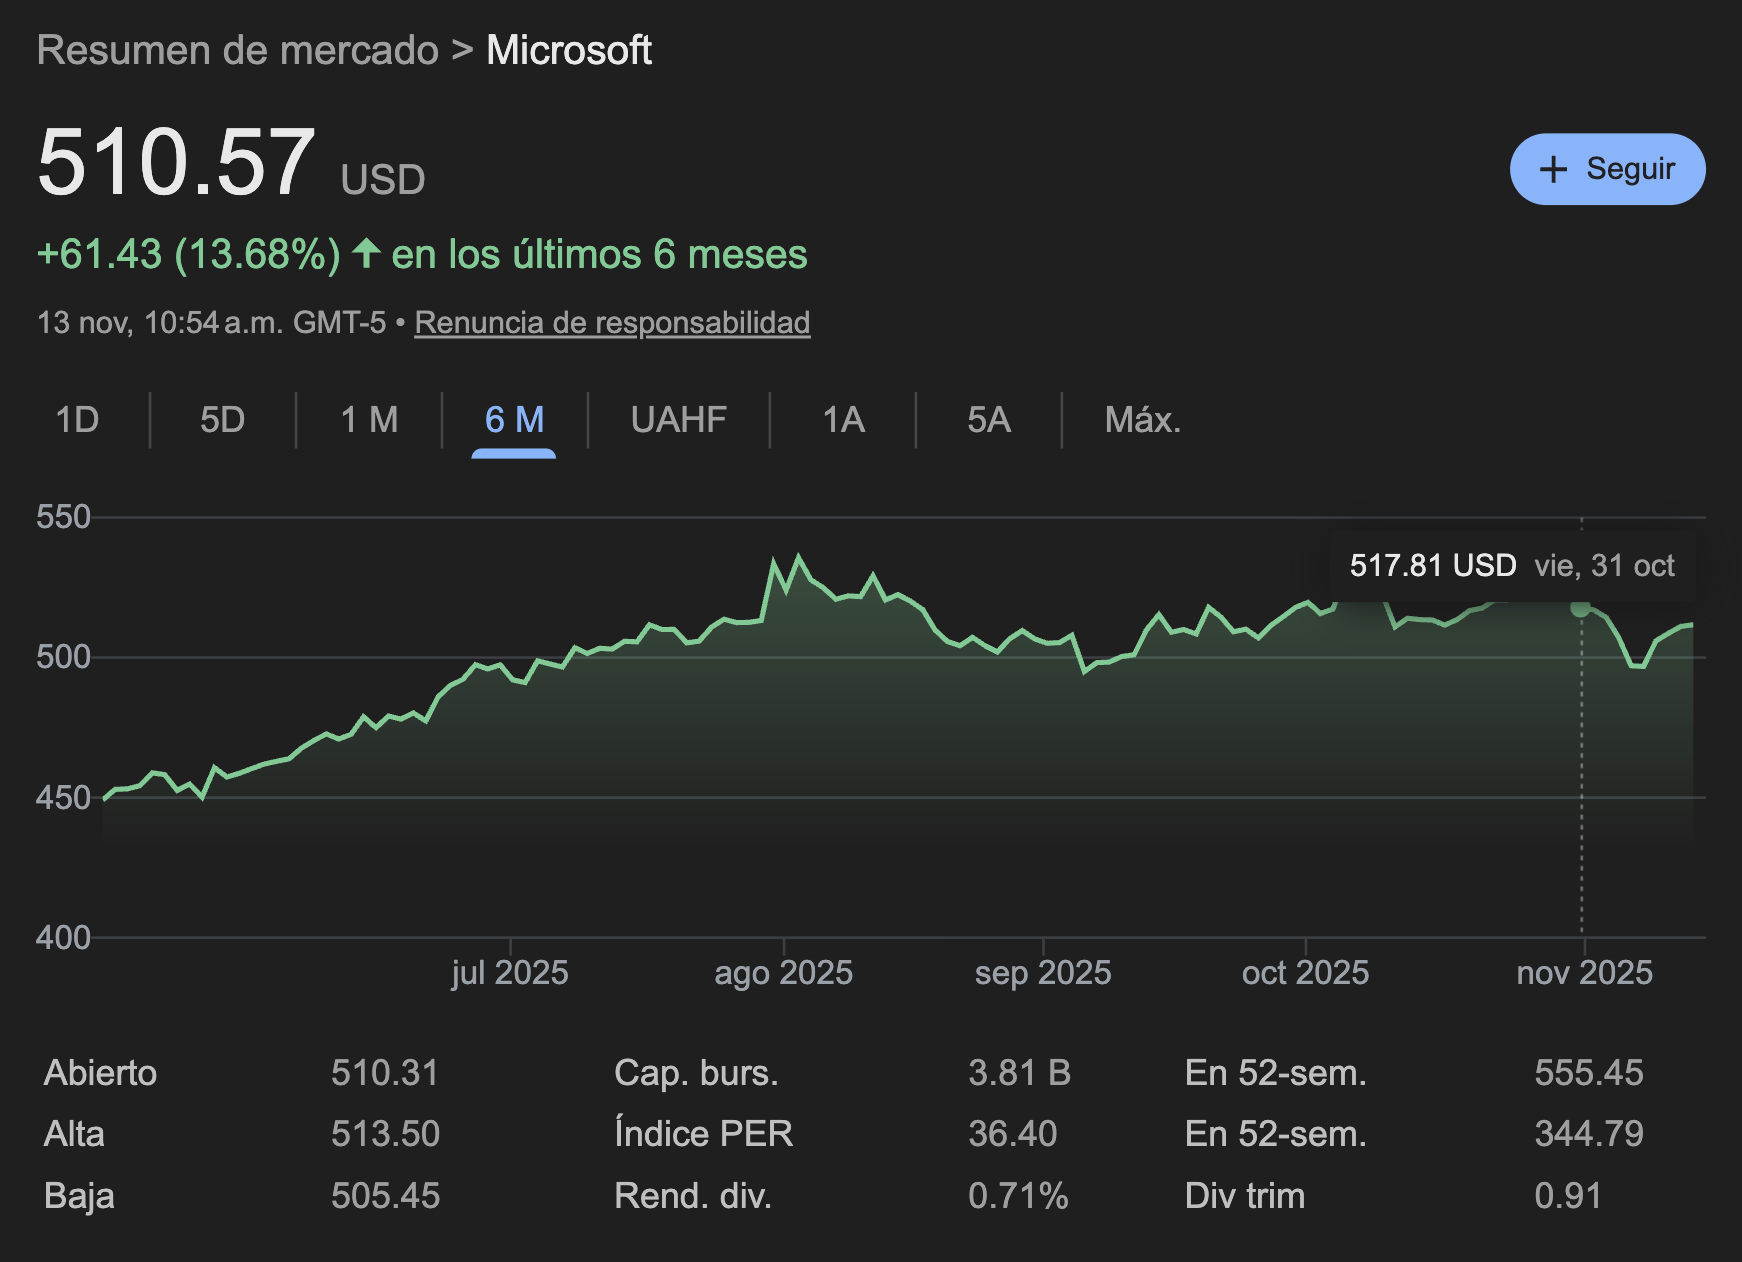

## Conclusiones y Reflexiones finales

A lo largo de las tres iteraciones del modelo, se observa una evolución significativa en la capacidad predictiva del modelo. En la primera red, el modelo presentaba un error considerable (MAE ≈ 57.48, RMSE ≈ 92.63, R² ≈ 0.42), lo que indicaba una sobre estimación de las tendencias reales del mercado. La gráfica de “Predicción vs Precio Real” mostraba una alta dispersión y fallas de seguimiento.

En la segunda iteración, después de implementar mejoras como EarlyStopping, una arquitectura más equilibrada (LSTM(128 a 64), Dropout(0.2), Dense(32, relu)) y la normalización refinada, el modelo alcanzó un rendimiento notablemente superior: MAE ≈ 9.33, RMSE ≈ 11.95 y un R² ≈ 0.99.
Las gráficas respaldan esta mejora:

La curva de pérdida evidencia un entrenamiento estable con una clara convergencia entre entrenamiento y validación, sin sobreajuste.

En la predicción vs precio real, ambas curvas (azul y naranja) se superponen casi completamente, mostrando un seguimiento muy preciso de las tendencias históricas.

Finalmente, la predicción del precio futuro (≈ $498.36 USD) se ubica consitente dentro del rango reciente de las acciones de Microsoft, lo que  valida la "estabilidad" del modelo ante datos nuevos.

En conjunto, los resultados reflejan que el modelo LSTM una vez ajustado y regularizado, puede capturar con alta precisión el dinamismo del mercado. Aunque la predicción de precios en bolsa siempre implica un alto nivel de incertidumbre, este ejercicio demuestra que una arquitectura profunda bien calibrada puede darnos resultados semi-confiables. 

### Áreas de mejora

1. Ajuste de hiperparámetros más exhaustivo(Implementar una búsqueda automatizada para encontrar la combinación óptima):
- Número de capas y neuronas
- Tamaño de la ventana de tiempo
- Tasa de aprendizaje
- Porcentaje de dropout

2. Aumento de datos y enriquecimiento de variables:
- Volumen de transacciones
- Indicadores técnicos (RSI, MACD, medias móviles)
- Noticias o sentiment analysis del mercado

Esto permitiría que el modelo aprenda relaciones más complejas entre factores externos y la evolución del precio.

3. Evaluación con datos fuera de muestra:
Es recomendable probar el modelo con datos completamente nuevos como semanas recientes no incluidas en el entrenamiento, para validar si el rendimiento se mantiene en condiciones reales.